**Group number**  
3

**Group members**  
Alexander Stoustrup  
Mathias Tyranski  
Benjamin Simonsen

In [1]:
import numpy as np
from scipy.optimize import minimize
import scipy.signal as si
import sympy as sp
import control as ct
from typing import List
from sympy.plotting import plot
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Math, Image
%matplotlib inline

def eq_disp(varstring, expr, unit=""):
    display(Latex(f"${varstring}={sp.latex(expr)} \: {unit}$"))
    
def reduce_feedback(G_fwd, G_bwd):
    """Assumes feedback is deducted from signal, if not
    change sign of feedback"""
    return sp.simplify(G_fwd/(1+G_fwd*G_bwd))

# RLC-Circuit

## Transfer function
Using the voltage divider rule
$$V_x = V_{in}\left(\frac{Z_x}{Z_{tot}}\right)$$

In [2]:
s, R, C, L, V_in = sp.symbols('s, R, C, L, V_in')
V_out = V_in*(R + 1/(C*s))/(R + 1/(C*s) + L*s)
eq_disp('V_{out}', V_out)

<IPython.core.display.Latex object>

Simplifying expression and finding the transfer function $H(s)$

In [3]:
eq_disp('V_{out}', sp.simplify(V_out))
H = sp.simplify(V_out/V_in)
eq_disp('H(s)=\\frac{V_{out}}{V_{in}}', H)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Bode diagram

Input values for capacitance, resistance and inductance

<IPython.core.display.Latex object>

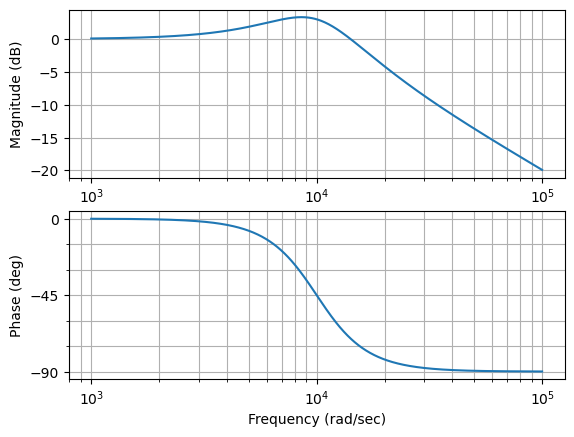

In [4]:
s = ct.tf('s')
R = 1*10**3
L = 0.1
C = 0.1*10**(-6)
H = (R + 1/(C*s))/(R + 1/(C*s) + L*s)
eq_disp('H(s)', H)
mag, phase, omega = ct.bode(H, dB=True)

## Cutoff frequency

<IPython.core.display.Latex object>

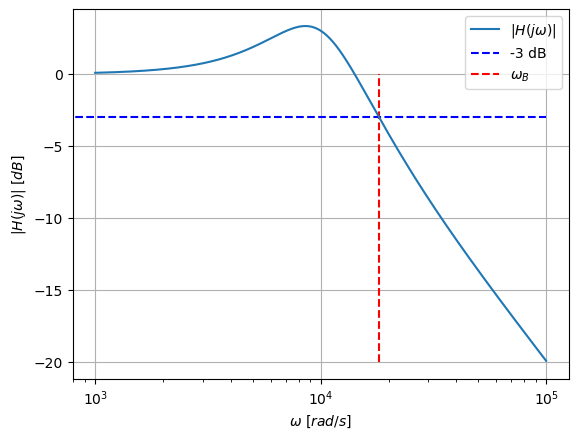

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

i_cutoff = find_nearest(20*np.log10(mag), -3)

omega_B = omega[i_cutoff]

eq_disp('\\omega_B', omega_B, 'rad/s')

plt.plot(omega,20*np.log10(mag), label='$|H(j\\omega)|$')
plt.hlines(-3, 0, 10**5, linestyle='--', color='b', label='-3 dB')
plt.vlines(omega_B, -20, 0, linestyle='--', color='r', label='$\\omega_B$')
plt.xlabel('$\\omega$ $[rad/s]$')
plt.ylabel('$|H(j\\omega)|$ $[dB]$')
plt.legend()
plt.grid()
plt.xscale('log')

## Is it a high pass or low pass filter?

It is a low pass filter

# Design of RC low pass filter

##  Design RC low pass filter to filter out noise

The frequency of the signal and noise is

In [6]:
f = 1/(1*10**(-3))
f_noise = 20/(1*10**(-3))
eq_disp('f', f, 'Hz')
eq_disp('f_{noise}', f_noise, 'Hz')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

So 90 % of the high frequency must be removed by the RC filter depicted below

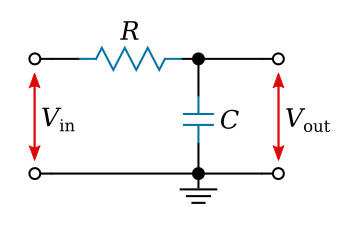

In [7]:
Image('rc-low-pass-filter.jpeg')

<IPython.core.display.Latex object>

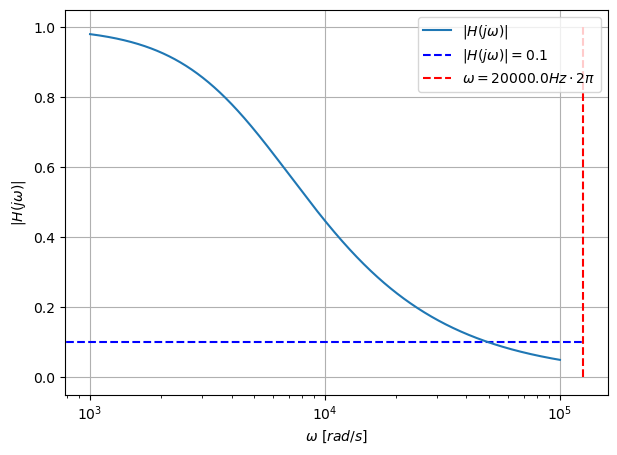

In [8]:
s = ct.tf('s')
R = 20*10**3
C = 0.001*10**(-5)
H = (1/(C*s))/(R + 1/(C*s))
eq_disp('H(s)', H)
mag, phase, omega = ct.bode(H, plot=False)

fig = plt.subplots(1, figsize=(7, 5))
plt.plot(omega,mag, label='$|H(j\\omega)|$')
plt.xlabel('$\\omega$ $[rad/s]$')
plt.ylabel('$|H(j\\omega)|$')
plt.hlines(0.1, 0, f_noise*2*np.pi, linestyle='--', color='b', label='$|H(j\\omega)|=0.1$')
plt.vlines(f_noise*2*np.pi, 0, 1, linestyle='--', color='r', label=f'$\\omega={f_noise} Hz \\cdot 2\\pi $')
plt.legend()
plt.grid()
plt.xscale('log')

The plot shows that more than 90 % of the high frequency noise signal is attenuated

## Corner frequency

In [9]:
i_cutoff = find_nearest(ct.mag2db(mag), -3)
omega_B = omega[i_cutoff]
eq_disp('\\omega_B', round(omega_B,2), 'rad/s')

<IPython.core.display.Latex object>

# Signal filtering with LabVIEW

A signal is generated in LabVIEW with the following settings

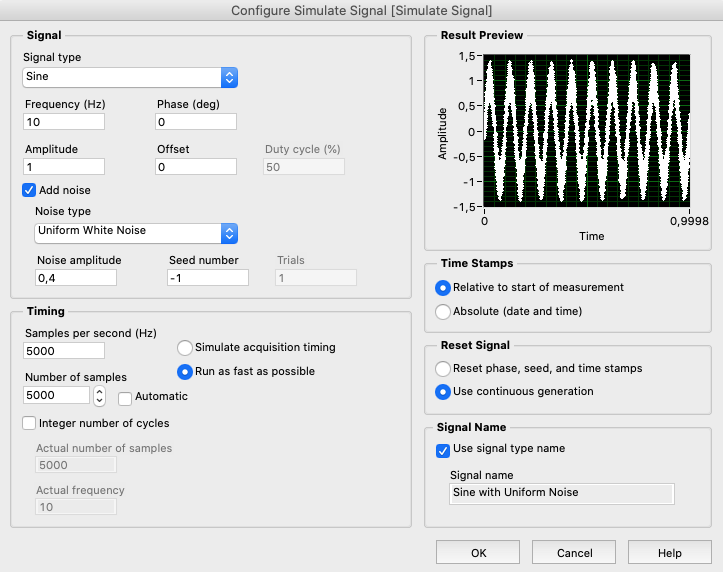

In [10]:
Image('Signal_settings.png')

Filtering with a higher order butterworth filter delays the signal. Here using the filter settings:

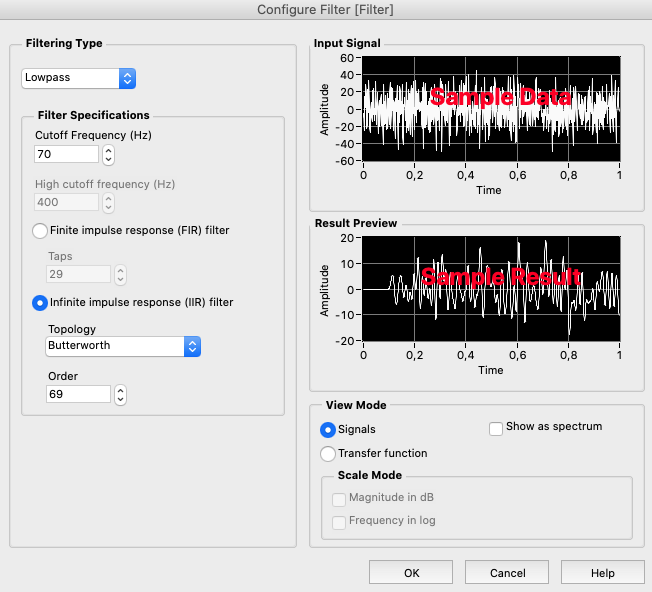

In [11]:
Image('filter_settings.png')

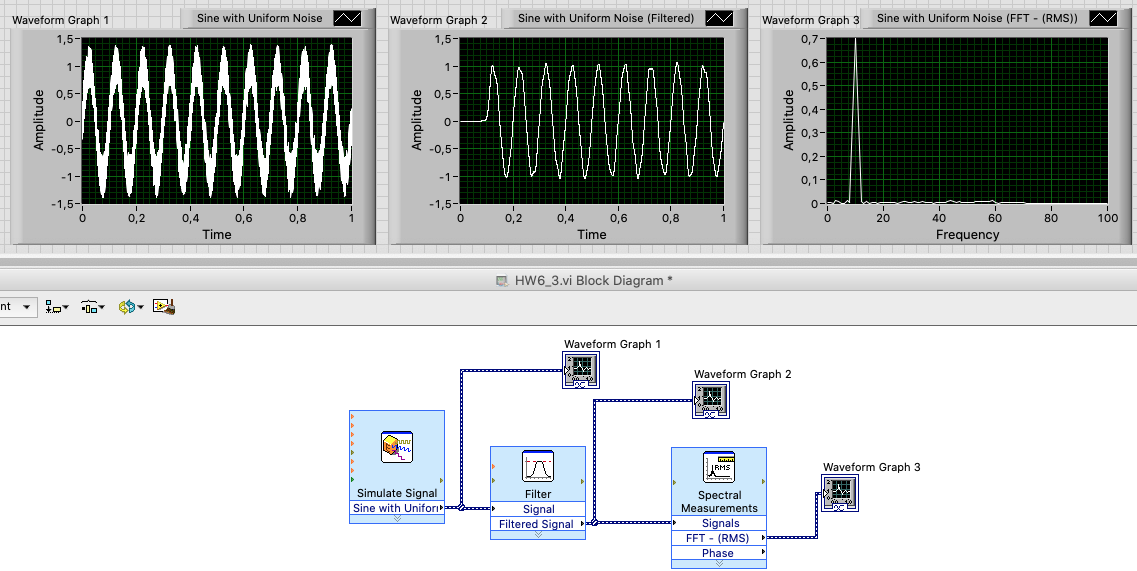

In [12]:
Image('Signal_filtering.png')

Using 1st order filters Butterworth, Chebyshev, Inverse Chebyshev, Elliptic and Bessel yield, respectively:

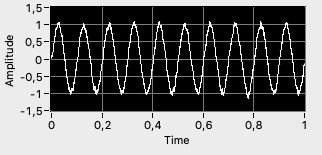

In [13]:
Image('Butterworth.png')

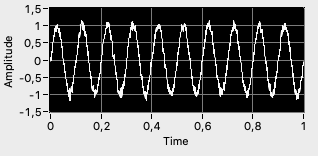

In [14]:
Image('Chebyshev.png')

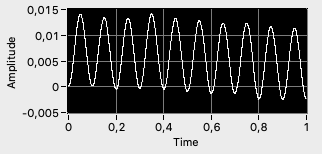

In [15]:
Image('InverseChebyshev.png')

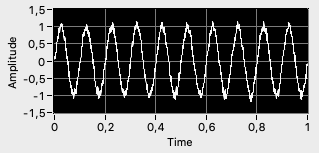

In [16]:
Image('Elliptic.png')

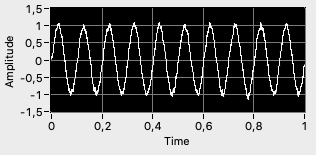

In [17]:
Image('Bessel.png')

As can be seen in the table:

$$
\begin{array}{|l|l|l|l|l|}
\hline \textbf { Filter } & \textbf { Passband } & \textbf { Stopband } & \begin{array}{l}
\textbf { Transition } \\
\textbf { Band }
\end{array} & \textbf { Specification } \\
\hline \textbf { Butterworth } & \text { Monotonic } & \text { Monotonic } & \text { Broad } & \begin{array}{l}
\text { Pass/Stop- } \\
\text { band }
\end{array} \\
\hline \textbf { Chebyshev-I } & \text { Equiripple } & \text { Monotonic } & \text { Narrow } & \text { Passband } \\
\hline \begin{array}{l}
\textbf { Chebyshev- } \\
\text { II }
\end{array} & \text { Monotonic } & \text { Equiripple } & \text { Narrow } & \text { Stopband } \\
\hline \textbf { Elliptic } & \text { Equiripple } & \text { Equiripple } & \begin{array}{l}
\text { Very } \\
\text { Narrow }
\end{array} & \text { Passband } \\
\hline
\end{array}
$$

The transfer functions of Butterworth, Chebyshev, Inverse Chebyshev, Elliptic and Bessel yield the responses, respectively:

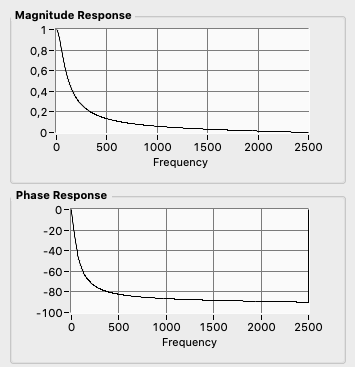

In [18]:
Image('ButterworthTF.png')

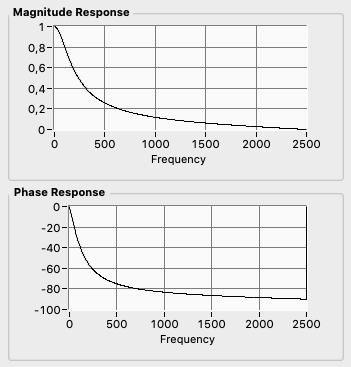

In [19]:
Image('ChebyshevTF.png')

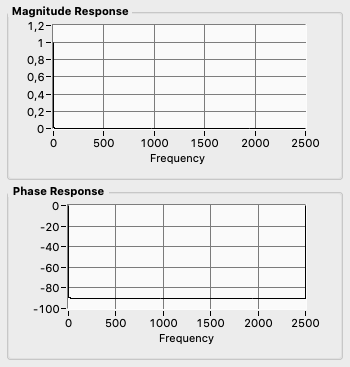

In [20]:
Image('InverseChebyshevTF.png')

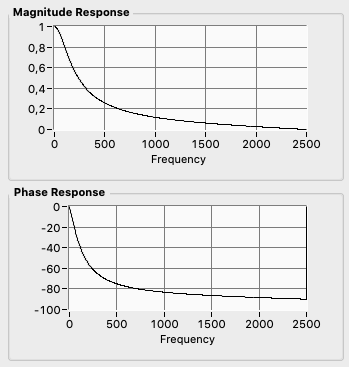

In [21]:
Image('EllipticTF.png')

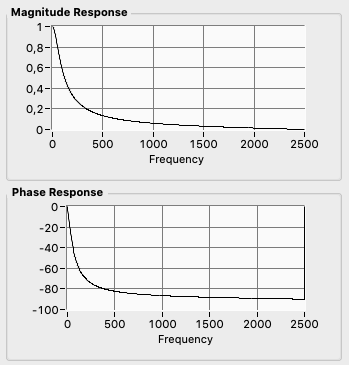

In [22]:
Image('BesselTF.png')